In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import random

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Bidirectional, GRU
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [3]:
data = np.genfromtxt('./data/clean_train.txt', delimiter=',', dtype=None)

/home/anton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


In [4]:
X = []
for sen in data:
    X.append(sen[0])

In [5]:
y = []
for sen in data:
    y.append(sen[1])

In [6]:
y = np.array(list(map(lambda x: 1 if x==1 else 0, y)))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
all_word = []
for elem in X:
    for w in elem.split(' '):
        all_word.append(w)
all_word = list(set(all_word))

In [9]:
vocal_length = len(all_word) + 13

In [10]:
#tokenizer = Tokenizer(num_words=vocal_length)
tokenizer = Tokenizer(num_words=vocal_length, oov_token=1)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)

In [11]:
longest_tweet = max([len(x) for x in X_train])

In [12]:
X_train = pad_sequences(X_train, longest_tweet, padding='post')

In [13]:
"""from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('data/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()
"""

'from numpy import array\nfrom numpy import asarray\nfrom numpy import zeros\n\nembeddings_dictionary = dict()\nglove_file = open(\'data/glove.twitter.27B.200d.txt\', encoding="utf8")\n\nfor line in glove_file:\n    records = line.split()\n    word = records[0]\n    vector_dimensions = asarray(records[1:], dtype=\'float32\')\n    embeddings_dictionary [word] = vector_dimensions\nglove_file.close()\n'

In [14]:
"""embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector"""

'embedding_matrix = zeros((vocab_size, 200))\nfor word, index in tokenizer.word_index.items():\n    embedding_vector = embeddings_dictionary.get(word)\n    if embedding_vector is not None:\n        embedding_matrix[index] = embedding_vector'

In [15]:
from keras.layers.recurrent import LSTM

"""model = Sequential()
embedding_layer = Embedding(vocal_length + 1, 200, input_length=longest_tweet)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])"""

model2 = Sequential()
embedding_layer = Embedding(vocal_length + 1, 200, input_length=longest_tweet)
model2.add(embedding_layer)
model2.add(GRU(512, return_sequences=True, dropout=0.2))
model2.add(GRU(128, return_sequences=True, dropout=0.4))
model2.add(Flatten()) # flatten the output of previous layer before feeding it to Dense layer
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [16]:
#print(model.summary())
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 46, 200)           18500200  
_________________________________________________________________
gru_1 (GRU)                  (None, 46, 512)           1095168   
_________________________________________________________________
gru_2 (GRU)                  (None, 46, 128)           246144    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5888)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5889      
Total params: 19,847,401
Trainable params: 19,847,401
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
#history = model.fit(X_train, y_train, batch_size=8, epochs=2, verbose=1, validation_split=0.2)

In [18]:
history = model2.fit(X_train, y_train, batch_size=512, epochs=4, verbose=1, validation_split=0.2)

/home/anton/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 116044 samples, validate on 29012 samples
Epoch 1/4
 12800/116044 [==>...........................] - ETA: 9:14 - loss: 0.6361 - acc: 0.6191

KeyboardInterrupt: 

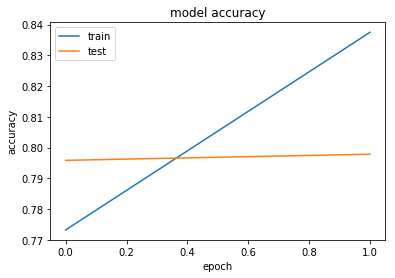

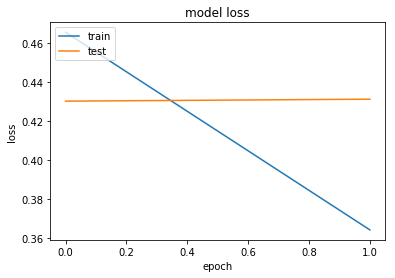

In [87]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [88]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, longest_tweet, padding='post')

In [89]:
preds = []
for l in X_test:
    preds.append(model.predict(l.reshape(1,-1)))

In [90]:
preds = [1 if x > 0.5 else 0 for x in preds]

good = 0
for i in range(len(y_test)):
    if y_test[i] == preds[i]:
        good += 1
        
print("accuracy : " + str(good/len(preds)))

accuracy : 0.5007583069074866


## Predict test data

In [22]:
def load_data(path, test=False):
    lines = []
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        lines = [l.strip() for l in lines]
    if test:
        ids = [l.split(',')[0] for l in lines]
        return ids, lines
    else:
        return lines

In [23]:
test_data = load_data('./data/clean_test_data.txt')

In [24]:
test_data[:3]

['sea doo pro sea scooter sport with the portable seadoo seascootersave air stay longer in the water and',
 'shuck well i work all week so now i cant come cheer you on oh and put those battery in your calculator',
 'i cant stay away from bug thats my baby']

In [25]:
def predict(test_data):
    preds = []
    test_data = tokenizer.texts_to_sequences(test_data)
    test_data = pad_sequences(test_data, longest_tweet, padding='post')
    for l in test_data:
        preds.append(model.predict(l.reshape(1,-1)))
    return preds

In [26]:
preds = predict(test_data)

In [27]:
predictions = [1 if x > 0.5 else -1 for x in preds]

In [28]:
len(predictions)

10000

In [30]:
with open('out/prediction_2.csv', 'w') as f:
    f.write('Id,Prediction'+'\n')
    index = 1
    for p in predictions:
        f.write(str(index)+','+str(p)+'\n')
        index += 1